# Customer Segmentation + Segment-wise Prediction

## Load & Prepare Data

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
#Load Dataset
df = pd.read_csv("customer_churn.csv")

## Basic Check

In [3]:
df.head()

,CustomerID,Tenure,MonthlyCharges,TotalCharges,Contract,PaymentMethod,PaperlessBilling,SeniorCitizen,Churn
0,C00001,6,64,1540,One year,Credit Card,No,1,0
1,C00002,21,113,1753,Month-to-month,Electronic Check,Yes,1,0
2,C00003,27,31,1455,Two year,Credit Card,No,1,0
3,C00004,53,29,7150,Month-to-month,Electronic Check,No,1,0
4,C00005,16,185,1023,One year,Electronic Check,No,1,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        500 non-null    object
 1   Tenure            500 non-null    int64 
 2   MonthlyCharges    500 non-null    int64 
 3   TotalCharges      500 non-null    int64 
 4   Contract          500 non-null    object
 5   PaymentMethod     500 non-null    object
 6   PaperlessBilling  500 non-null    object
 7   SeniorCitizen     500 non-null    int64 
 8   Churn             500 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 35.3+ KB


In [5]:
df.isnull().sum()

CustomerID          0
Tenure              0
MonthlyCharges      0
TotalCharges        0
Contract            0
PaymentMethod       0
PaperlessBilling    0
SeniorCitizen       0
Churn               0
dtype: int64

In [6]:
#Drop ID column
df = df.drop("CustomerID", axis=1)

In [7]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [8]:
print(df_encoded.dtypes)

Tenure                            int64
MonthlyCharges                    int64
TotalCharges                      int64
SeniorCitizen                     int64
Churn                             int64
Contract_One year                  bool
Contract_Two year                  bool
PaymentMethod_Credit Card          bool
PaymentMethod_Electronic Check     bool
PaperlessBilling_Yes               bool
dtype: object


In [9]:
#Separate Target
X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

In [10]:
print(X.dtypes)

Tenure                            int64
MonthlyCharges                    int64
TotalCharges                      int64
SeniorCitizen                     int64
Contract_One year                  bool
Contract_Two year                  bool
PaymentMethod_Credit Card          bool
PaymentMethod_Electronic Check     bool
PaperlessBilling_Yes               bool
dtype: object


In [11]:
#Scale Features (For Clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Clustering (Segmentation)

In [12]:
#KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_encoded["Segment_KMeans"] = kmeans.fit_predict(X_scaled)

C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


## Elbow Method

C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\Hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, 

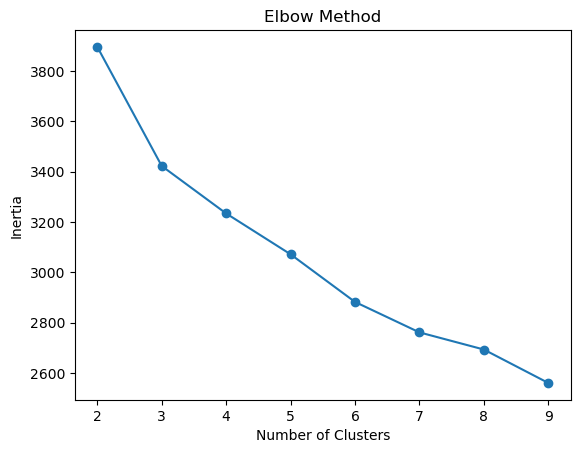

In [25]:
inertia = []

for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 10), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()


In [13]:
print(df_encoded["Segment_KMeans"].value_counts())

Segment_KMeans
0    232
2    144
1    124
Name: count, dtype: int64


In [14]:
#Hierarchical Clustering
hier = AgglomerativeClustering(n_clusters=3)
df_encoded["Segment_Hierarchical"] = hier.fit_predict(X_scaled)

In [15]:
print(df_encoded["Segment_Hierarchical"].value_counts())

Segment_Hierarchical
0    243
1    138
2    119
Name: count, dtype: int64


## Analyze Segments

In [16]:
segment_analysis = df_encoded.groupby("Segment_KMeans").mean(numeric_only=True)
print(segment_analysis)

                   Tenure  MonthlyCharges  TotalCharges  SeniorCitizen  \
Segment_KMeans                                                           
0               37.452586      116.737069   4088.387931       0.469828   
1               37.024194      107.282258   4216.282258       0.524194   
2               34.625000      114.111111   4497.333333       0.520833   

                   Churn  Contract_One year  Contract_Two year  \
Segment_KMeans                                                   
0               0.103448           0.547414                0.0   
1               0.153226           0.475806                0.0   
2               0.069444           0.000000                1.0   

                PaymentMethod_Credit Card  PaymentMethod_Electronic Check  \
Segment_KMeans                                                              
0                                   0.000                        0.500000   
1                                   1.000                        0.

In [17]:
print(df_encoded.dtypes)

Tenure                            int64
MonthlyCharges                    int64
TotalCharges                      int64
SeniorCitizen                     int64
Churn                             int64
Contract_One year                  bool
Contract_Two year                  bool
PaymentMethod_Credit Card          bool
PaymentMethod_Electronic Check     bool
PaperlessBilling_Yes               bool
Segment_KMeans                    int32
Segment_Hierarchical              int64
dtype: object


In [18]:
print("Churn" in df.columns)

True


## Build Separate Models Per Segment

In [19]:
#Loop Through Segments
segments = df_encoded["Segment_KMeans"].unique()

for seg in segments:
    
    print(f"\n====== Segment {seg} ======")
    
    segment_df = df_encoded[df_encoded["Segment_KMeans"] == seg]
    
    X_seg = segment_df.drop(["Churn", "Segment_KMeans", "Segment_Hierarchical"], axis=1)
    y_seg = segment_df["Churn"]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_seg, y_seg, test_size=0.2, random_state=42
    )
    
    model = RandomForestClassifier(
        n_estimators=100,
        class_weight="balanced",
        random_state=42
    )
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    print(classification_report(y_test, preds))
    
    print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))


====== Segment 1 ======
              precision    recall  f1-score   support

           0       1.00      0.95      0.97        20
           1       0.83      1.00      0.91         5

    accuracy                           0.96        25
   macro avg       0.92      0.97      0.94        25
weighted avg       0.97      0.96      0.96        25

ROC-AUC: 1.0

====== Segment 0 ======
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00         6

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47

ROC-AUC: 1.0

====== Segment 2 ======
              precision    recall  f1-score   support

           0       0.96      0.96      0.96        28
           1       0.00      0.00      0.00         1

    accuracy                           0.93        29
   macro avg       0.48    

## Hyperparameter Tuning

In [21]:
segment_0 = df_encoded[df_encoded["Segment_KMeans"] == 0]

X_seg = segment_0.drop(["Churn", "Segment_KMeans", "Segment_Hierarchical"], axis=1)
y_seg = segment_0["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X_seg, y_seg, test_size=0.2, random_state=42
)

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 5, 10]
}

grid = GridSearchCV(
    RandomForestClassifier(class_weight="balanced", random_state=42),
    param_grid,
    cv=3,
    scoring="f1"
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_

preds = best_model.predict(X_test)

print("Best Parameters:", grid.best_params_)
print(classification_report(y_test, preds))

Best Parameters: {'max_depth': 5, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        41
           1       1.00      1.00      1.00         6

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47

